In [12]:
%reset
import numpy as np 
import pandas as pd 
import xarray as xr 
import cartopy 
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import warnings
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.offsetbox as offsetbox
import seaborn.objects

warnings.filterwarnings("ignore")
#from sklearn_xarray import Stacker, Select

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [13]:
root_path='/data/keeling/a/rytam2/ccf_model_spread/data/preprocessed/'
kernel_path='/data/keeling/a/rytam2/a/kernels/gcms/'

In [14]:
#AMIP data
ts_amip = xr.open_mfdataset(root_path+'ts_amip_CMIP5&6_198201_200812.nc')
eis_amip = xr.open_mfdataset(root_path+'eis_amip_CMIP5&6_198201_200812.nc')
tadv_amip = xr.open_mfdataset(root_path+'tadv_amip_CMIP5&6_198201_200812.nc')*24*3600
rh_amip = xr.open_mfdataset(root_path+'hur_amip_CMIP5&6_198201_200812.nc')
omega_amip = xr.open_mfdataset(root_path+'wap_amip_CMIP5&6_198201_200812.nc')*864
ws_amip = xr.open_mfdataset(root_path+'ws_amip_CMIP5&6_198201_200812.nc')

#historical data
ts_hist = xr.open_mfdataset(root_path+'ts_obshist_CMIP5&6_2008.nc')
eis_hist = xr.open_mfdataset(root_path+'eis_obshist_CMIP5&6_2008.nc')
tadv_hist = xr.open_mfdataset(root_path+'tadv_obshist_CMIP5&6_2008.nc')*24*3600
rh_hist = xr.open_mfdataset(root_path+'hur_obshist_CMIP5&6_2008.nc')
omega_hist = xr.open_mfdataset(root_path+'wap_obshist_CMIP5&6_2008.nc')*864
ws_hist = xr.open_mfdataset(root_path+'ws_obshist_CMIP5&6_2008.nc')

#abrupt data

# 5x5 interpolated CMIP output 
ts_abrupt = xr.open_mfdataset(root_path+'20221019/ts_4xCO2_CMIP5&6_Y1-150.nc') #SST 
eis_abrupt = xr.open_mfdataset(root_path+'20221019/eis_4xCO2_CMIP5&6_Y1-150.nc') #EIS 
tadv_abrupt = xr.open_mfdataset(root_path+'20221019/tadv_4xCO2_CMIP5&6_Y1-150.nc')*24*3600 #Temperature Advection 
rh_abrupt = xr.open_mfdataset(root_path+'20221019/hur_4xCO2_CMIP5&6_Y1-150.nc') # Relative Humidity 
omega_abrupt = xr.open_mfdataset(root_path+'20221019/wap_4xCO2_CMIP5&6_Y1-150.nc')*864 # Vertical advection 
ws_abrupt = xr.open_mfdataset(root_path+'20221019/ws_4xCO2_CMIP5&6_Y1-150.nc') #Surface Windspeed 

# Rename Model Names 
name_list = ['CCSM4','CanESM2','CanESM5','E3SM-1-0','GFDL-CM4','HadGEM2','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC-ES2L','MIROC-ESM',
                     'MIROC5','MIROC6','MPI-ESM','MRI-CGCM3','MRI-ESM2-0','UKESM1-0-LL']

model_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl','mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm']

rename_dict = dict(zip(sorted(name_list), sorted(model_list)))

ts_abrupt = ts_abrupt.rename(rename_dict) 
eis_abrupt = eis_abrupt.rename(rename_dict)
tadv_abrupt = tadv_abrupt.rename(rename_dict)
rh_abrupt = rh_abrupt.rename(rename_dict)
omega_abrupt = omega_abrupt.rename(rename_dict)
ws_abrupt = ws_abrupt.rename(rename_dict)

In [15]:
# Load Kernels 
kernels_list = glob.glob(kernel_path+'*.nc');

dict_sst_kernels = {}
dict_eis_kernels = {}
dict_tadv_kernels = {}
dict_rh_kernels = {}
dict_omega_kernels = {}
dict_ws_kernels = {}

modelname_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl',
                'mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm'] #order must be sticktly followed to match kernels_list


# Get dRdxi from files
for filename in kernels_list:
    kernel=xr.open_mfdataset(filename)
    j = kernels_list.index(filename)
    modelname=modelname_list[j]
    dict_sst_kernels["%s"%modelname] = kernel.isel(i=0).dRdxi
    dict_eis_kernels["%s"%modelname] = kernel.isel(i=1).dRdxi
    dict_tadv_kernels["%s"%modelname] = kernel.isel(i=2).dRdxi
    dict_rh_kernels["%s"%modelname] = kernel.isel(i=3).dRdxi
    dict_omega_kernels["%s"%modelname] = kernel.isel(i=4).dRdxi
    dict_ws_kernels["%s"%modelname] = kernel.isel(i=5).dRdxi
    
# Define new coords 
coords = {'lat':(['latitude'],kernel.lat.values),
         'lon':(['longitude'],kernel.lon.values)}

# Create kernel xarray variables 
sst_kernels = xr.Dataset(data_vars=dict_sst_kernels,coords=coords);
eis_kernels = xr.Dataset(data_vars=dict_eis_kernels,coords=coords);
tadv_kernels = xr.Dataset(data_vars=dict_tadv_kernels,coords=coords);
rh_kernels = xr.Dataset(data_vars=dict_rh_kernels,coords=coords);
omega_kernels = xr.Dataset(data_vars=dict_omega_kernels,coords=coords);
ws_kernels = xr.Dataset(data_vars=dict_ws_kernels,coords=coords);

# Rename to avoid duplicate dimensions
sst_kernels = sst_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
eis_kernels = eis_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
tadv_kernels = tadv_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
rh_kernels = rh_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
omega_kernels = omega_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
ws_kernels = ws_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});

In [16]:
# Remove seasonal cycle from measurements 
def remove_seasonality(x):
    return x - x.mean(dim='time')

#AMIP
# Group data by month and remove seasonality
ts_noseason_amip = ts_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason_amip = eis_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason_amip = tadv_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason_amip = rh_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason_amip = omega_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason_amip = ws_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 


#Hist
# Group data by month and remove seasonality
ts_noseason_hist = ts_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason_hist = eis_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason_hist = tadv_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason_hist = rh_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason_hist = omega_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason_hist = ws_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 


#Abrupt
# Group data by month and remove seasonality
ts_noseason_abrupt = ts_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason_abrupt = eis_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason_abrupt = tadv_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason_abrupt = rh_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason_abrupt = omega_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason_abrupt = ws_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 

In [17]:
# Remove seasonal cycle from measurements 
def approx_change(x,degree):
    if degree == 1: 
        poly=x.polyfit(dim='time', deg=1)
        fit = xr.polyval(x['time'],poly.polyfit_coefficients)
        change = fit.isel(time=-1)-fit.isel(time=0)
        return change
    
def normalize(x): 
    glob = x.mean('lat').mean('lon')
    norm = x/glob
    return x

def ensemble_mean(x):
    return x.to_array(dim='models').mean('models')

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return


def shrink_width_fig1(axes):
    box = axes.get_position()
    box.x0 = box.x0 + .015
    box.x1 = box.x1 + .008
    axes.set_position(box)
    return None

def shrink_width_suppfig1(axes):
    box = axes.get_position()
    box.x0 = box.x0 + 0.098
    box.x1 = box.x1 - 0.062
    axes.set_position(box)
    return None

def shrink_width_fig2(axes):
    box = axes.get_position()
    box.x0 = box.x0 + .0125
    box.x1 = box.x1 - 0.0125
    axes.set_position(box)
    return None

def shrink_width_suppfig2(axes):
    box = axes.get_position()
    box.x0 = box.x0 + 0.11
    box.x1 = box.x1 - 0.11
    axes.set_position(box)
    return None

# Get Changes in CCF (per temperature change)

In [18]:
# Get approximated change in CCF across period 

#AMIP
da_list=[approx_change(ts_noseason_amip[var],1).rename(var) for var in modelname_list]
dSST_hat_amip = xr.merge(da_list)
dT_glob_amip = ensemble_mean(dSST_hat_amip.mean('lat').mean('lon')).values
dSST_hat_amip = dSST_hat_amip/dT_glob_amip
da_list=[approx_change(eis_noseason_amip[var],1).rename(var) for var in modelname_list]
dEIS_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(tadv_noseason_amip[var],1).rename(var) for var in modelname_list]
dTadv_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(rh_noseason_amip[var],1).rename(var) for var in modelname_list]
dRH_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(omega_noseason_amip[var],1).rename(var) for var in modelname_list]
dOmega_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(ws_noseason_amip[var],1).rename(var) for var in modelname_list]
dWS_hat_amip = xr.merge(da_list)/dT_glob_amip

# Historical 
da_list=[approx_change(ts_noseason_hist[var],1).rename(var) for var in modelname_list]
dSST_hat_hist = xr.merge(da_list)
dT_glob_hist = ensemble_mean(dSST_hat_hist.mean('lat').mean('lon'))
dSST_hat_hist = dSST_hat_hist/dT_glob_hist
da_list=[approx_change(eis_noseason_hist[var],1).rename(var) for var in modelname_list]
dEIS_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(tadv_noseason_hist[var],1).rename(var) for var in modelname_list]
dTadv_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(rh_noseason_hist[var],1).rename(var) for var in modelname_list]
dRH_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(omega_noseason_hist[var],1).rename(var) for var in modelname_list]
dOmega_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(ws_noseason_hist[var],1).rename(var) for var in modelname_list]
dWS_hat_hist = xr.merge(da_list)/dT_glob_hist

# Abrupt Fast response
da_list=[approx_change(ts_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dSST_hat_fast = xr.merge(da_list)
dT_glob_fast = ensemble_mean(dSST_hat_fast.mean('lat').mean('lon'))
dSST_hat_fast = dSST_hat_fast/dT_glob_fast
da_list=[approx_change(eis_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dEIS_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(tadv_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dTadv_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(rh_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dRH_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(omega_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dOmega_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(ws_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dWS_hat_fast = xr.merge(da_list)/dT_glob_fast

# Abrupt Slow response
da_list=[approx_change(ts_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dSST_hat_slow = xr.merge(da_list)
dT_glob_slow = ensemble_mean(dSST_hat_slow.mean('lat').mean('lon'))
dSST_hat_slow = dSST_hat_slow/dT_glob_slow
da_list=[approx_change(eis_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dEIS_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(tadv_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dTadv_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(rh_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dRH_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(omega_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dOmega_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(ws_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dWS_hat_slow = xr.merge(da_list)/dT_glob_slow


In [19]:
# Ensemble Mean Changes

# AMIP
dSST_hat_bar_amip = ensemble_mean(dSST_hat_amip)
dEIS_hat_bar_amip = ensemble_mean(dEIS_hat_amip)
dTadv_hat_bar_amip = ensemble_mean(dTadv_hat_amip)
dRH_hat_bar_amip = ensemble_mean(dRH_hat_amip)
dOmega_hat_bar_amip = ensemble_mean(dOmega_hat_amip)
dWS_hat_bar_amip = ensemble_mean(dWS_hat_amip)

# Hist
dSST_hat_bar_hist = ensemble_mean(dSST_hat_hist)
dEIS_hat_bar_hist = ensemble_mean(dEIS_hat_hist)
dTadv_hat_bar_hist = ensemble_mean(dTadv_hat_hist)
dRH_hat_bar_hist = ensemble_mean(dRH_hat_hist)
dOmega_hat_bar_hist = ensemble_mean(dOmega_hat_hist)
dWS_hat_bar_hist = ensemble_mean(dWS_hat_hist)

# Abrupt Fast response
dSST_hat_bar_fast = ensemble_mean(dSST_hat_fast)
dEIS_hat_bar_fast = ensemble_mean(dEIS_hat_fast)
dTadv_hat_bar_fast = ensemble_mean(dTadv_hat_fast)
dRH_hat_bar_fast = ensemble_mean(dRH_hat_fast)
dOmega_hat_bar_fast = ensemble_mean(dOmega_hat_fast)
dWS_hat_bar_fast = ensemble_mean(dWS_hat_fast)

# Abrupt Slow response
dSST_hat_bar_slow = ensemble_mean(dSST_hat_slow)
dEIS_hat_bar_slow = ensemble_mean(dEIS_hat_slow)
dTadv_hat_bar_slow = ensemble_mean(dTadv_hat_slow)
dRH_hat_bar_slow = ensemble_mean(dRH_hat_slow)
dOmega_hat_bar_slow = ensemble_mean(dOmega_hat_slow)
dWS_hat_bar_slow = ensemble_mean(dWS_hat_slow)

In [20]:
# Zonal Mean

# AMIP
dSST_hat_bar_amip_zonavg = dSST_hat_bar_amip.mean('lon')
dEIS_hat_bar_amip_zonavg = dEIS_hat_bar_amip.mean('lon')
dTadv_hat_bar_amip_zonavg = dTadv_hat_bar_amip.mean('lon')
dRH_hat_bar_amip_zonavg = dRH_hat_bar_amip.mean('lon')
dOmega_hat_bar_amip_zonavg = dOmega_hat_bar_amip.mean('lon')
dWS_hat_bar_amip_zonavg = dWS_hat_bar_amip.mean('lon')

# Hist
dSST_hat_bar_hist_zonavg = dSST_hat_bar_hist.mean('lon')
dEIS_hat_bar_hist_zonavg = dEIS_hat_bar_hist.mean('lon')
dTadv_hat_bar_hist_zonavg = dTadv_hat_bar_hist.mean('lon')
dRH_hat_bar_hist_zonavg = dRH_hat_bar_hist.mean('lon')
dOmega_hat_bar_hist_zonavg = dOmega_hat_bar_hist.mean('lon')
dWS_hat_bar_hist_zonavg = dWS_hat_bar_hist.mean('lon')

# Abrupt Fast response
dSST_hat_bar_fast_zonavg = dSST_hat_bar_fast.mean('lon')
dEIS_hat_bar_fast_zonavg = dEIS_hat_bar_fast.mean('lon')
dTadv_hat_bar_fast_zonavg = dTadv_hat_bar_fast.mean('lon')
dRH_hat_bar_fast_zonavg = dRH_hat_bar_fast.mean('lon')
dOmega_hat_bar_fast_zonavg = dOmega_hat_bar_fast.mean('lon')
dWS_hat_bar_fast_zonavg = dWS_hat_bar_fast.mean('lon')

# Abrupt Slow response
dSST_hat_bar_slow_zonavg = dSST_hat_bar_slow.mean('lon')
dEIS_hat_bar_slow_zonavg = dEIS_hat_bar_slow.mean('lon')
dTadv_hat_bar_slow_zonavg = dTadv_hat_bar_slow.mean('lon')
dRH_hat_bar_slow_zonavg = dRH_hat_bar_slow.mean('lon')
dOmega_hat_bar_slow_zonavg = dOmega_hat_bar_slow.mean('lon')
dWS_hat_bar_slow_zonavg = dWS_hat_bar_slow.mean('lon')

# Get Feedback Changes 

In [21]:
# AMIP
dR_SST_hat_amip = dSST_hat_amip * sst_kernels
dR_EIS_hat_amip = dEIS_hat_amip * eis_kernels
dR_Tadv_hat_amip = dTadv_hat_amip * tadv_kernels
dR_RH_hat_amip = dRH_hat_amip * rh_kernels
dR_Omega_hat_amip = dOmega_hat_amip * omega_kernels
dR_WS_hat_amip = dWS_hat_amip * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_amip_bar = ensemble_mean(dR_SST_hat_amip)
dR_EIS_hat_amip_bar = ensemble_mean(dR_EIS_hat_amip)
dR_Tadv_hat_amip_bar = ensemble_mean(dR_Tadv_hat_amip)
dR_RH_hat_amip_bar = ensemble_mean(dR_RH_hat_amip)
dR_Omega_hat_amip_bar = ensemble_mean(dR_Omega_hat_amip)
dR_WS_hat_amip_bar = ensemble_mean(dR_WS_hat_amip)


# Historical
dR_SST_hat_hist = dSST_hat_hist * sst_kernels
dR_EIS_hat_hist = dEIS_hat_hist * eis_kernels
dR_Tadv_hat_hist = dTadv_hat_hist * tadv_kernels
dR_RH_hat_hist = dRH_hat_hist * rh_kernels
dR_Omega_hat_hist = dOmega_hat_hist * omega_kernels
dR_WS_hat_hist = dWS_hat_hist * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_hist_bar = ensemble_mean(dR_SST_hat_hist)
dR_EIS_hat_hist_bar= ensemble_mean(dR_EIS_hat_hist)
dR_Tadv_hat_hist_bar = ensemble_mean(dR_Tadv_hat_hist)
dR_RH_hat_hist_bar = ensemble_mean(dR_RH_hat_hist)
dR_Omega_hat_hist_bar = ensemble_mean(dR_Omega_hat_hist)
dR_WS_hat_hist_bar = ensemble_mean(dR_WS_hat_hist)


# Abrupt fast response
dR_SST_hat_fast = dSST_hat_fast * sst_kernels
dR_EIS_hat_fast = dEIS_hat_fast * eis_kernels
dR_Tadv_hat_fast = dTadv_hat_fast * tadv_kernels
dR_RH_hat_fast = dRH_hat_fast * rh_kernels
dR_Omega_hat_fast = dOmega_hat_fast * omega_kernels
dR_WS_hat_fast = dWS_hat_fast * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_fast_bar = ensemble_mean(dR_SST_hat_fast)
dR_EIS_hat_fast_bar = ensemble_mean(dR_EIS_hat_fast)
dR_Tadv_hat_fast_bar = ensemble_mean(dR_Tadv_hat_fast)
dR_RH_hat_fast_bar = ensemble_mean(dR_RH_hat_fast)
dR_Omega_hat_fast_bar = ensemble_mean(dR_Omega_hat_fast)
dR_WS_hat_fast_bar = ensemble_mean(dR_WS_hat_fast)


# Abrupt slow response
dR_SST_hat_slow = dSST_hat_slow * sst_kernels
dR_EIS_hat_slow = dEIS_hat_slow * eis_kernels
dR_Tadv_hat_slow = dTadv_hat_slow * tadv_kernels
dR_RH_hat_slow = dRH_hat_slow * rh_kernels
dR_Omega_hat_slow = dOmega_hat_slow * omega_kernels
dR_WS_hat_slow = dWS_hat_slow * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_slow_bar = ensemble_mean(dR_SST_hat_slow)
dR_EIS_hat_slow_bar = ensemble_mean(dR_EIS_hat_slow)
dR_Tadv_hat_slow_bar = ensemble_mean(dR_Tadv_hat_slow)
dR_RH_hat_slow_bar = ensemble_mean(dR_RH_hat_slow)
dR_Omega_hat_slow_bar = ensemble_mean(dR_Omega_hat_slow)
dR_WS_hat_slow_bar = ensemble_mean(dR_WS_hat_slow)


#Total low-cloud feedback
dR_hat_amip = dR_SST_hat_amip + dR_EIS_hat_amip + dR_Tadv_hat_amip + dR_RH_hat_amip + dR_Omega_hat_amip + dR_WS_hat_amip
dR_hat_fast = dR_SST_hat_fast + dR_EIS_hat_fast + dR_Tadv_hat_fast + dR_RH_hat_fast + dR_Omega_hat_fast + dR_WS_hat_fast
dR_hat_slow = dR_SST_hat_slow + dR_EIS_hat_slow + dR_Tadv_hat_slow + dR_RH_hat_slow + dR_Omega_hat_slow + dR_WS_hat_slow
dR_hat_hist = dR_SST_hat_hist + dR_EIS_hat_hist + dR_Tadv_hat_hist + dR_RH_hat_hist + dR_Omega_hat_hist + dR_WS_hat_hist

In [22]:
# Zonal Mean Feedback

# AMIP
dR_SST_hat_amip_bar_zonavg = dR_SST_hat_amip_bar.mean('lon')
dR_EIS_hat_amip_bar_zonavg = dR_EIS_hat_amip_bar.mean('lon')
dR_Tadv_hat_amip_bar_zonavg = dR_Tadv_hat_amip_bar.mean('lon')
dR_RH_hat_amip_bar_zonavg = dR_RH_hat_amip_bar.mean('lon')
dR_Omega_hat_amip_bar_zonavg = dR_Omega_hat_amip_bar.mean('lon')
dR_WS_hat_amip_bar_zonavg = dR_WS_hat_amip_bar.mean('lon')

# Hist
dR_SST_hat_hist_bar_zonavg = dR_SST_hat_hist_bar.mean('lon')
dR_EIS_hat_hist_bar_zonavg = dR_EIS_hat_hist_bar.mean('lon')
dR_Tadv_hat_hist_bar_zonavg = dR_Tadv_hat_hist_bar.mean('lon')
dR_RH_hat_hist_bar_zonavg = dR_RH_hat_hist_bar.mean('lon')
dR_Omega_hat_hist_bar_zonavg = dR_Omega_hat_hist_bar.mean('lon')
dR_WS_hat_hist_bar_zonavg = dR_WS_hat_hist_bar.mean('lon')

# Abrupt Fast response
dR_SST_hat_fast_bar_zonavg = dR_SST_hat_fast_bar.mean('lon')
dR_EIS_hat_fast_bar_zonavg = dR_EIS_hat_fast_bar.mean('lon')
dR_Tadv_hat_fast_bar_zonavg = dR_Tadv_hat_fast_bar.mean('lon')
dR_RH_hat_fast_bar_zonavg = dR_RH_hat_fast_bar.mean('lon')
dR_Omega_hat_fast_bar_zonavg = dR_Omega_hat_fast_bar.mean('lon')
dR_WS_hat_fast_bar_zonavg = dR_WS_hat_fast_bar.mean('lon')

# Abrupt Slow response
dR_SST_hat_slow_bar_zonavg = dR_SST_hat_slow_bar.mean('lon')
dR_EIS_hat_slow_bar_zonavg = dR_EIS_hat_slow_bar.mean('lon')
dR_Tadv_hat_slow_bar_zonavg = dR_Tadv_hat_slow_bar.mean('lon')
dR_RH_hat_slow_bar_zonavg = dR_RH_hat_slow_bar.mean('lon')
dR_Omega_hat_slow_bar_zonavg = dR_Omega_hat_slow_bar.mean('lon')
dR_WS_hat_slow_bar_zonavg = dR_WS_hat_slow_bar.mean('lon')

# Global Feedback and Feedback per CCF spread across Models 

In [25]:
def to_dataframe(xrdataset,experiment,variable):
    globmean=xrdataset.mean('lat',skipna=True).mean('lon',skipna=True).to_array('models')
    globmodelmean=globmean.mean('models')
    df=pd.DataFrame(globmean.values, columns=['dR/dT'])
    df=df.append(pd.DataFrame([globmodelmean.values], columns=['dR/dT']))
    df.loc[:, 'models'] = modelname_list+['mean']
    df[['experiment','var']]=experiment,variable
    return df


df = to_dataframe(dR_hat_amip,'amip','Total')
df = df.append(to_dataframe(dR_hat_hist,'hist','Total'))
df = df.append(to_dataframe(dR_hat_fast,'fast','Total'))
df = df.append(to_dataframe(dR_hat_slow,'slow','Total'))
df = df.append(to_dataframe(dR_SST_hat_amip,'amip','SST'))
df = df.append(to_dataframe(dR_EIS_hat_amip,'amip','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_amip,'amip','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_amip,'amip','RH'))
df = df.append(to_dataframe(dR_Omega_hat_amip,'amip','Omega'))
df = df.append(to_dataframe(dR_WS_hat_amip,'amip','WS'))
df = df.append(to_dataframe(dR_SST_hat_hist,'hist','SST'))
df = df.append(to_dataframe(dR_EIS_hat_hist,'hist','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_hist,'hist','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_hist,'hist','RH'))
df = df.append(to_dataframe(dR_Omega_hat_hist,'hist','Omega'))
df = df.append(to_dataframe(dR_WS_hat_hist,'hist','WS'))
df = df.append(to_dataframe(dR_SST_hat_fast,'fast','SST'))
df = df.append(to_dataframe(dR_EIS_hat_fast,'fast','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_fast,'fast','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_fast,'fast','RH'))
df = df.append(to_dataframe(dR_Omega_hat_fast,'fast','Omega'))
df = df.append(to_dataframe(dR_WS_hat_fast,'fast','WS'))
df = df.append(to_dataframe(dR_SST_hat_slow,'slow','SST'))
df = df.append(to_dataframe(dR_EIS_hat_slow,'slow','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_slow,'slow','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_slow,'slow','RH'))
df = df.append(to_dataframe(dR_Omega_hat_slow,'slow','Omega'))
df = df.append(to_dataframe(dR_WS_hat_slow,'slow','WS'))

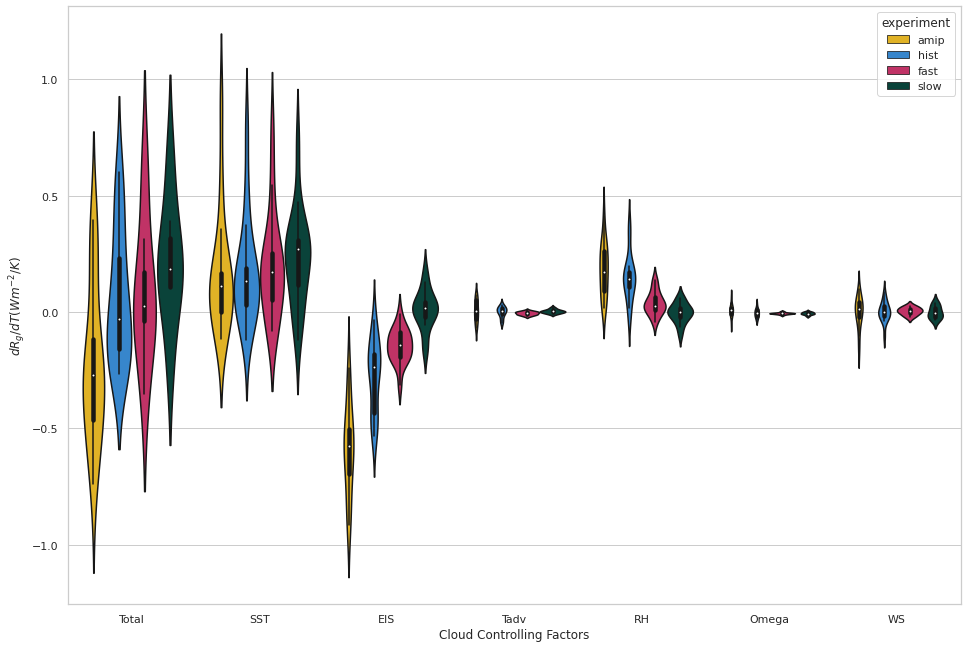

In [19]:
"""seaborn.violinplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, bw='scott', cut=2, scale='area',\
                   scale_hue=True, gridsize=100, width=0.8, inner='box', split=False, \
                   dodge=True, orient=None, linewidth=None, color=None, palette=None, saturation=0.75, \
                   ax=None, **kwargs)"""


fig = plt.figure(figsize=(16,11))
ax1 = plt.axes()

seaborn.set(style = 'whitegrid')
seaborn.violinplot(x ="var",
             y ="dR/dT",
             hue ="experiment",
            ax=ax1,inner='box',palette=["#FFC107", "#1E88E5", "#D81B60","#004D40"],
             data = df)

ax1.set(xlabel='Cloud Controlling Factors', ylabel='$dR_{g}/dT (Wm^{-2}/K)$');

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/comp/violinplot_dRg_allmodels_allexperiments.png',  dpi=400, bbox_inches='tight')

In [ ]:
# Supp
import seaborn.objects as so


p1=so.Plot(data=df, x="var", y="dR/dT", color="experiment",marker="models")\
                  .label(color=str.capitalize,marker=str.capitalize,x='Cloud Controlling Factors', y='$dR_{g}/dT (Wm^{-2}/K)$')\
                  .layout(size=(18, 10)).scale(color=["#FFC107", "#1E88E5", "#D81B60","#004D40"],pointsize=20)\
                  .add(so.Dot(), so.Dodge(gap=10))\
                  .theme({**axes_style("whitegrid")})\
                  .save('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/comp/dotplot_dRg_permodels_allexperiments.png',  dpi=400, bbox_inches='tight')

p1

# Uncertainty Analysis per CCF using Taylor Approximation

In [26]:
# Kernel Ensemble Average
sst_kernels_bar = ensemble_mean(sst_kernels)
eis_kernels_bar = ensemble_mean(eis_kernels)
tadv_kernels_bar = ensemble_mean(tadv_kernels)
rh_kernels_bar = ensemble_mean(rh_kernels)
omega_kernels_bar = ensemble_mean(omega_kernels)
ws_kernels_bar = ensemble_mean(ws_kernels)

#Model deviations for AMIP 
dEIS_prime_amip = dEIS_hat_amip - dEIS_hat_bar_amip
dTadv_prime_amip = dTadv_hat_amip - dTadv_hat_bar_amip
dRH_prime_amip = dRH_hat_amip - dRH_hat_bar_amip
dOmega_prime_amip = dOmega_hat_amip - dOmega_hat_bar_amip
dWS_prime_amip = dWS_hat_amip - dWS_hat_bar_amip

#Model deviations for Historical
dEIS_prime_hist = dEIS_hat_hist - dEIS_hat_bar_hist
dTadv_prime_hist = dTadv_hat_hist - dTadv_hat_bar_hist
dRH_prime_hist = dRH_hat_hist - dRH_hat_bar_hist
dOmega_prime_hist = dOmega_hat_hist - dOmega_hat_bar_hist
dWS_prime_hist = dWS_hat_hist - dWS_hat_bar_hist

#Model deviations for Abrupt-4xCO2 fast response 
dEIS_prime_fast = dEIS_hat_fast - dEIS_hat_bar_fast
dTadv_prime_fast = dTadv_hat_fast - dTadv_hat_bar_fast
dRH_prime_fast = dRH_hat_fast - dRH_hat_bar_fast
dOmega_prime_fast = dOmega_hat_fast - dOmega_hat_bar_fast
dWS_prime_fast = dWS_hat_fast - dWS_hat_bar_fast

#Model deviations for Abrupt-4xCO2 slow response 
dEIS_prime_slow = dEIS_hat_slow - dEIS_hat_bar_slow
dTadv_prime_slow = dTadv_hat_slow - dTadv_hat_bar_slow
dRH_prime_slow = dRH_hat_slow - dRH_hat_bar_slow
dOmega_prime_slow = dOmega_hat_slow - dOmega_hat_bar_slow
dWS_prime_slow = dWS_hat_slow - dWS_hat_bar_slow



# kernel deviation from mean 
sst_kernels_prime = sst_kernels-sst_kernels_bar
eis_kernels_prime = eis_kernels-eis_kernels_bar
tadv_kernels_prime = tadv_kernels-tadv_kernels_bar
rh_kernels_prime = rh_kernels-rh_kernels_bar
omega_kernels_prime = omega_kernels-omega_kernels_bar
ws_kernels_prime = ws_kernels-ws_kernels_bar

In [27]:
# Model SST Sensitivity
dR_model_to_sst_prime_amip = sst_kernels_prime*dSST_hat_bar_amip
dR_model_to_sst_prime_var_amip = dR_model_to_sst_prime_amip.to_array(dim='models').var('models')
dR_model_to_sst_prime_fast = sst_kernels_prime*dSST_hat_bar_fast
dR_model_to_sst_prime_var_fast = dR_model_to_sst_prime_fast.to_array(dim='models').var('models')
dR_model_to_sst_prime_slow = sst_kernels_prime*dSST_hat_bar_slow
dR_model_to_sst_prime_var_slow = dR_model_to_sst_prime_slow.to_array(dim='models').var('models')
dR_model_to_sst_prime_hist = sst_kernels_prime*dSST_hat_bar_hist
dR_model_to_sst_prime_var_hist = dR_model_to_sst_prime_hist.to_array(dim='models').var('models')

# Intrinsic EIS changes 
dR_intrin_eis_prime_amip = (eis_kernels_bar*dEIS_prime_amip)
dR_intrin_eis_prime_var_amip = dR_intrin_eis_prime_amip.to_array(dim='models').var('models')
dR_intrin_eis_prime_fast = (eis_kernels_bar*dEIS_prime_fast)
dR_intrin_eis_prime_var_fast = dR_intrin_eis_prime_fast.to_array(dim='models').var('models')
dR_intrin_eis_prime_slow = (eis_kernels_bar*dEIS_prime_slow)
dR_intrin_eis_prime_var_slow = dR_intrin_eis_prime_slow.to_array(dim='models').var('models')
dR_intrin_eis_prime_hist = (eis_kernels_bar*dEIS_prime_hist)
dR_intrin_eis_prime_var_hist = dR_intrin_eis_prime_hist.to_array(dim='models').var('models')

# Model EIS Sensitivity 
dR_model_to_eis_prime_amip = eis_kernels_prime*dEIS_hat_bar_amip
dR_model_to_eis_prime_var_amip = dR_model_to_eis_prime_amip.to_array(dim='models').var('models')
dR_model_to_eis_prime_fast = eis_kernels_prime*dEIS_hat_bar_fast
dR_model_to_eis_prime_var_fast = dR_model_to_eis_prime_fast.to_array(dim='models').var('models')
dR_model_to_eis_prime_slow = eis_kernels_prime*dEIS_hat_bar_slow
dR_model_to_eis_prime_var_slow = dR_model_to_eis_prime_slow.to_array(dim='models').var('models')
dR_model_to_eis_prime_hist = eis_kernels_prime*dEIS_hat_bar_hist
dR_model_to_eis_prime_var_hist = dR_model_to_eis_prime_hist.to_array(dim='models').var('models')

# Intrinsic Tadv changes 
dR_intrin_tadv_prime_amip = (tadv_kernels_bar*dTadv_prime_amip)
dR_intrin_tadv_prime_var_amip = dR_intrin_tadv_prime_amip.to_array(dim='models').var('models')
dR_intrin_tadv_prime_fast = (tadv_kernels_bar*dTadv_prime_fast)
dR_intrin_tadv_prime_var_fast = dR_intrin_tadv_prime_fast.to_array(dim='models').var('models')
dR_intrin_tadv_prime_slow = (tadv_kernels_bar*dTadv_prime_slow)
dR_intrin_tadv_prime_var_slow = dR_intrin_tadv_prime_slow.to_array(dim='models').var('models')
dR_intrin_tadv_prime_hist = (tadv_kernels_bar*dTadv_prime_hist)
dR_intrin_tadv_prime_var_hist = dR_intrin_tadv_prime_hist.to_array(dim='models').var('models')

# Model Tadv Sensitivity 
dR_model_to_tadv_prime_amip = tadv_kernels_prime*dTadv_hat_bar_amip
dR_model_to_tadv_prime_var_amip = dR_model_to_tadv_prime_amip.to_array(dim='models').var('models')
dR_model_to_tadv_prime_fast = tadv_kernels_prime*dTadv_hat_bar_fast
dR_model_to_tadv_prime_var_fast = dR_model_to_tadv_prime_fast.to_array(dim='models').var('models')
dR_model_to_tadv_prime_slow = tadv_kernels_prime*dTadv_hat_bar_slow
dR_model_to_tadv_prime_var_slow = dR_model_to_tadv_prime_slow.to_array(dim='models').var('models')
dR_model_to_tadv_prime_hist = tadv_kernels_prime*dTadv_hat_bar_hist
dR_model_to_tadv_prime_var_hist = dR_model_to_tadv_prime_hist.to_array(dim='models').var('models')

# Intrinsic RH changes 
dR_intrin_rh_prime_amip = (rh_kernels_bar*dRH_prime_amip)
dR_intrin_rh_prime_var_amip = dR_intrin_rh_prime_amip.to_array(dim='models').var('models')
dR_intrin_rh_prime_fast = (rh_kernels_bar*dRH_prime_fast)
dR_intrin_rh_prime_var_fast = dR_intrin_rh_prime_fast.to_array(dim='models').var('models')
dR_intrin_rh_prime_slow = (rh_kernels_bar*dRH_prime_slow)
dR_intrin_rh_prime_var_slow = dR_intrin_rh_prime_slow.to_array(dim='models').var('models')
dR_intrin_rh_prime_hist = (rh_kernels_bar*dRH_prime_hist)
dR_intrin_rh_prime_var_hist = dR_intrin_rh_prime_hist.to_array(dim='models').var('models')

# Model RH Sensitivity 
dR_model_to_rh_prime_amip = rh_kernels_prime*dRH_hat_bar_amip
dR_model_to_rh_prime_var_amip = dR_model_to_rh_prime_amip.to_array(dim='models').var('models')
dR_model_to_rh_prime_fast = rh_kernels_prime*dRH_hat_bar_fast
dR_model_to_rh_prime_var_fast = dR_model_to_rh_prime_fast.to_array(dim='models').var('models')
dR_model_to_rh_prime_slow = rh_kernels_prime*dRH_hat_bar_slow
dR_model_to_rh_prime_var_slow = dR_model_to_rh_prime_slow.to_array(dim='models').var('models')
dR_model_to_rh_prime_hist = rh_kernels_prime*dRH_hat_bar_hist
dR_model_to_rh_prime_var_hist = dR_model_to_rh_prime_hist.to_array(dim='models').var('models')

# Intrinsic Omega changes 
dR_intrin_omega_prime_amip = (omega_kernels_bar*dOmega_prime_amip)
dR_intrin_omega_prime_var_amip = dR_intrin_omega_prime_amip.to_array(dim='models').var('models')
dR_intrin_omega_prime_fast = (omega_kernels_bar*dOmega_prime_fast)
dR_intrin_omega_prime_var_fast = dR_intrin_omega_prime_fast.to_array(dim='models').var('models')
dR_intrin_omega_prime_slow = (omega_kernels_bar*dOmega_prime_slow)
dR_intrin_omega_prime_var_slow = dR_intrin_omega_prime_slow.to_array(dim='models').var('models')
dR_intrin_omega_prime_hist = (omega_kernels_bar*dOmega_prime_hist)
dR_intrin_omega_prime_var_hist = dR_intrin_omega_prime_hist.to_array(dim='models').var('models')

# Model Omega Sensitivity 
dR_model_to_omega_prime_amip = omega_kernels_prime*dOmega_hat_bar_amip
dR_model_to_omega_prime_var_amip = dR_model_to_omega_prime_amip.to_array(dim='models').var('models')
dR_model_to_omega_prime_fast = omega_kernels_prime*dOmega_hat_bar_fast
dR_model_to_omega_prime_var_fast = dR_model_to_omega_prime_fast.to_array(dim='models').var('models')
dR_model_to_omega_prime_slow = omega_kernels_prime*dOmega_hat_bar_slow
dR_model_to_omega_prime_var_slow = dR_model_to_omega_prime_slow.to_array(dim='models').var('models')
dR_model_to_omega_prime_hist = omega_kernels_prime*dOmega_hat_bar_hist
dR_model_to_omega_prime_var_hist = dR_model_to_omega_prime_hist.to_array(dim='models').var('models')

# Intrinsic WS changes 
dR_intrin_ws_prime_amip = (ws_kernels_bar*dWS_prime_amip)
dR_intrin_ws_prime_var_amip = dR_intrin_ws_prime_amip.to_array(dim='models').var('models')
dR_intrin_ws_prime_fast = (ws_kernels_bar*dWS_prime_fast)
dR_intrin_ws_prime_var_fast = dR_intrin_ws_prime_fast.to_array(dim='models').var('models')
dR_intrin_ws_prime_slow = (ws_kernels_bar*dWS_prime_slow)
dR_intrin_ws_prime_var_slow = dR_intrin_ws_prime_slow.to_array(dim='models').var('models')
dR_intrin_ws_prime_hist = (ws_kernels_bar*dWS_prime_hist)
dR_intrin_ws_prime_var_hist = dR_intrin_ws_prime_hist.to_array(dim='models').var('models')

# Model WS Sensitivity 
dR_model_to_ws_prime_amip = ws_kernels_prime*dWS_hat_bar_amip
dR_model_to_ws_prime_var_amip = dR_model_to_ws_prime_amip.to_array(dim='models').var('models')
dR_model_to_ws_prime_fast = ws_kernels_prime*dWS_hat_bar_fast
dR_model_to_ws_prime_var_fast = dR_model_to_ws_prime_fast.to_array(dim='models').var('models')
dR_model_to_ws_prime_slow = ws_kernels_prime*dWS_hat_bar_slow
dR_model_to_ws_prime_var_slow = dR_model_to_ws_prime_slow.to_array(dim='models').var('models')
dR_model_to_ws_prime_hist = ws_kernels_prime*dWS_hat_bar_hist
dR_model_to_ws_prime_var_hist = dR_model_to_ws_prime_hist.to_array(dim='models').var('models')



# Total Variance 
dR_intrin_var_amip = dR_intrin_eis_prime_var_amip+dR_intrin_tadv_prime_var_amip+dR_intrin_rh_prime_var_amip+dR_intrin_omega_prime_var_amip+dR_intrin_ws_prime_var_amip
dR_sensitivity_var_amip = dR_model_to_sst_prime_var_amip+dR_model_to_eis_prime_var_amip+dR_model_to_tadv_prime_var_amip+dR_model_to_rh_prime_var_amip+dR_model_to_omega_prime_var_amip+dR_model_to_ws_prime_var_amip
dR_hat_var_amip = dR_hat_amip.to_array('models').var('models')
var_ratio_amip = (dR_intrin_var_amip+dR_sensitivity_var_amip)/dR_hat_var_amip
var_diff_amip = dR_hat_var_amip-(dR_intrin_var_amip+dR_sensitivity_var_amip)

dR_intrin_var_fast = dR_intrin_eis_prime_var_fast+dR_intrin_tadv_prime_var_fast+dR_intrin_rh_prime_var_fast+dR_intrin_omega_prime_var_fast+dR_intrin_ws_prime_var_fast
dR_sensitivity_var_fast = dR_model_to_sst_prime_var_fast+dR_model_to_eis_prime_var_fast+dR_model_to_tadv_prime_var_fast+dR_model_to_rh_prime_var_fast+dR_model_to_omega_prime_var_fast+dR_model_to_ws_prime_var_fast
dR_hat_var_fast = dR_hat_fast.to_array('models').var('models')
var_ratio_fast = (dR_intrin_var_fast+dR_sensitivity_var_fast)/dR_hat_var_fast
var_diff_fast = dR_hat_var_fast-(dR_intrin_var_fast+dR_sensitivity_var_fast)

dR_intrin_var_slow = dR_intrin_eis_prime_var_slow+dR_intrin_tadv_prime_var_slow+dR_intrin_rh_prime_var_slow+dR_intrin_omega_prime_var_slow+dR_intrin_ws_prime_var_slow
dR_sensitivity_var_slow = dR_model_to_sst_prime_var_slow+dR_model_to_eis_prime_var_slow+dR_model_to_tadv_prime_var_slow+dR_model_to_rh_prime_var_slow+dR_model_to_omega_prime_var_slow+dR_model_to_ws_prime_var_slow
dR_hat_var_slow = dR_hat_slow.to_array('models').var('models')
var_ratio_slow = (dR_intrin_var_slow+dR_sensitivity_var_slow)/dR_hat_var_slow
var_diff_slow = dR_hat_var_slow-(dR_intrin_var_slow+dR_sensitivity_var_slow)

dR_intrin_var_hist = dR_intrin_eis_prime_var_hist+dR_intrin_tadv_prime_var_hist+dR_intrin_rh_prime_var_hist+dR_intrin_omega_prime_var_hist+dR_intrin_ws_prime_var_hist
dR_sensitivity_var_hist = dR_model_to_sst_prime_var_hist+dR_model_to_eis_prime_var_hist+dR_model_to_tadv_prime_var_hist+dR_model_to_rh_prime_var_hist+dR_model_to_omega_prime_var_hist+dR_model_to_ws_prime_var_hist
dR_hat_var_hist = dR_hat_hist.to_array('models').var('models')
var_ratio_hist = (dR_intrin_var_hist+dR_sensitivity_var_hist)/dR_hat_var_hist
var_diff_hist = dR_hat_var_hist-(dR_intrin_var_hist+dR_sensitivity_var_hist)

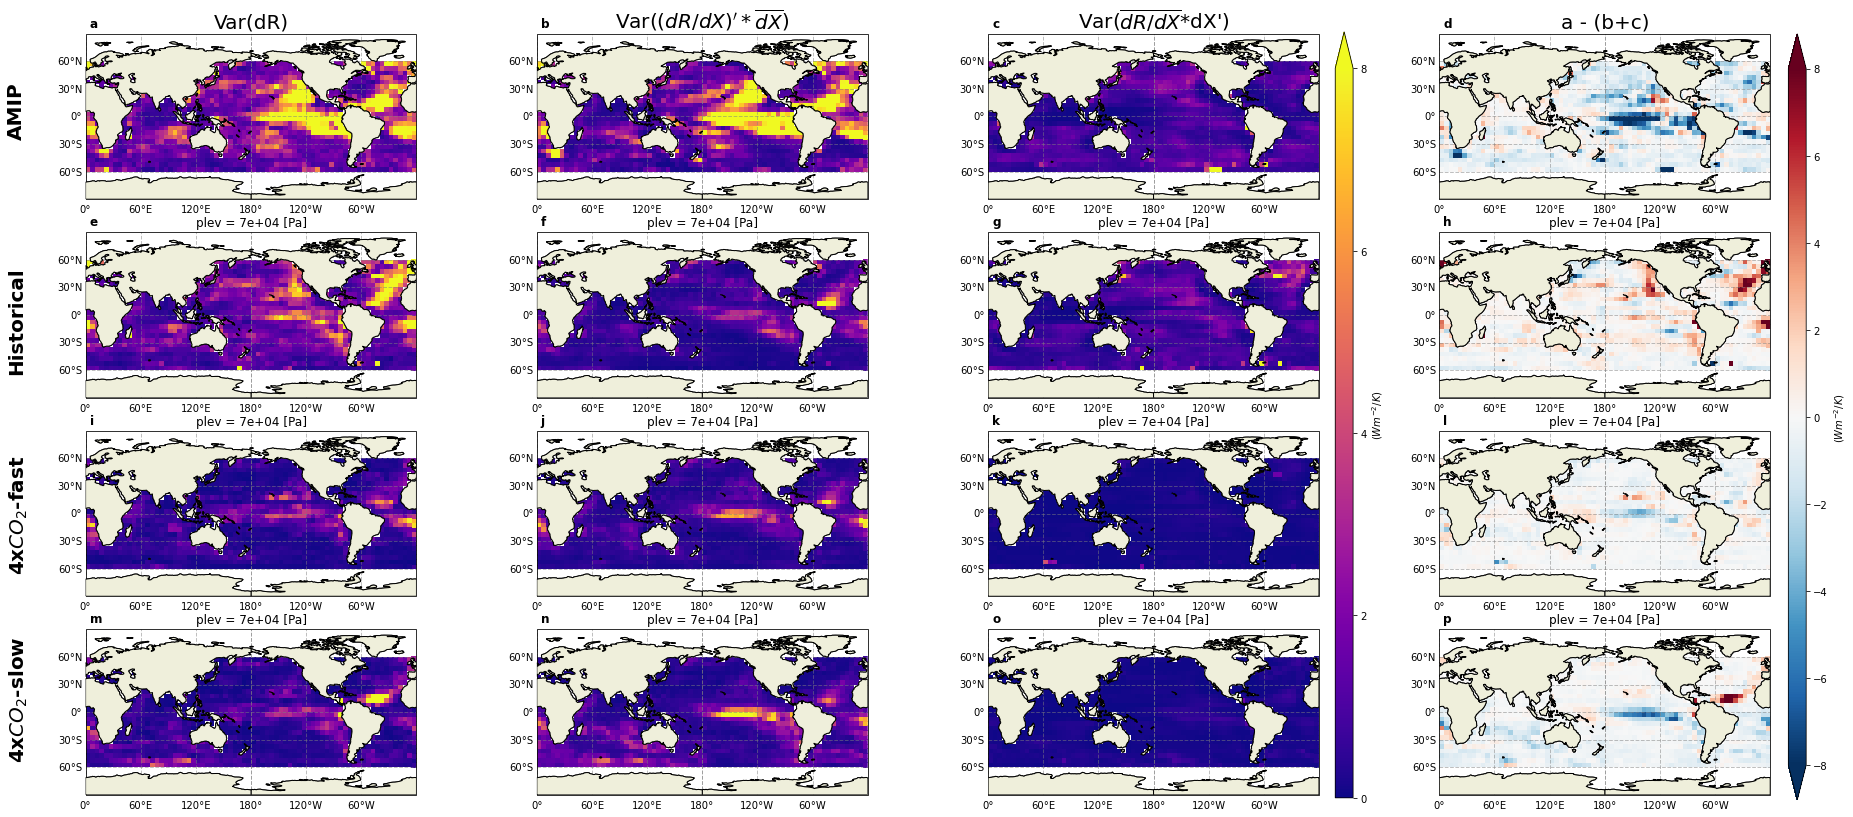

In [28]:
# Fig 3: Variance of Feedback Changes in 4 experiments with Single Colorbars

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
#figcheck 
fig = plt.figure(figsize=(31,14))
ax1 = plt.subplot2grid((4,4), (0,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = plt.subplot2grid((4,4), (0,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = plt.subplot2grid((4,4), (0,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = plt.subplot2grid((4,4), (0,3), projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = plt.subplot2grid((4,4), (1,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = plt.subplot2grid((4,4), (1,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax7 = plt.subplot2grid((4,4), (1,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax8 = plt.subplot2grid((4,4), (1,3), projection=ccrs.PlateCarree(central_longitude=180.0))
ax9 = plt.subplot2grid((4,4), (2,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax10 = plt.subplot2grid((4,4), (2,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax11 = plt.subplot2grid((4,4), (2,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax12 = plt.subplot2grid((4,4), (2,3), projection=ccrs.PlateCarree(central_longitude=180.0))
ax13 = plt.subplot2grid((4,4), (3,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax14 = plt.subplot2grid((4,4), (3,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax15 = plt.subplot2grid((4,4), (3,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax16 = plt.subplot2grid((4,4), (3,3), projection=ccrs.PlateCarree(central_longitude=180.0))

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7.xlabels_top = False
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl8.xlabels_top = False
gl9 = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl9.xlabels_top = False
gl10 = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl10.xlabels_top = False
gl11 = ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl11.xlabels_top = False
gl12 = ax12.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl12.xlabels_top = False
gl13 = ax13.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl13.xlabels_top = False
gl14 = ax14.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl14.xlabels_top = False
gl15 = ax15.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl15.xlabels_top = False
gl16 = ax16.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl16.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines(),ax7.coastlines(), ax8.coastlines(), ax9.coastlines(),ax10.coastlines(), ax11.coastlines(), ax12.coastlines(), ax13.coastlines(), ax14.coastlines(), ax15.coastlines(), ax16.coastlines()

ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax2.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax3.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax4.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax5.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax6.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax7.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax8.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax9.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax10.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax11.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax12.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax13.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax14.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax15.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
ax16.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')

im1= dR_hat_var_amip.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
dR_sensitivity_var_amip.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmin=0,vmax=8,)
dR_intrin_var_amip.plot(ax=ax3,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmin=0,vmax=8,)
im2 = var_diff_amip.plot(ax=ax4,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False,vmax=8,vmin=-8)
dR_hat_var_hist.plot(ax=ax5,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=8,vmin=0)
dR_sensitivity_var_hist.plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False, vmax=8,vmin=0)
dR_intrin_var_hist.plot(ax=ax7,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False, vmax=8,vmin=0)
var_diff_hist.plot(ax=ax8,transform=ccrs.PlateCarree(), cmap='RdBu_r',add_colorbar=False,vmax=8,vmin=-8,)
dR_hat_var_fast.plot(ax=ax9,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
dR_sensitivity_var_fast.plot(ax=ax10,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
dR_intrin_var_fast.plot(ax=ax11,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
var_diff_fast.plot(ax=ax12,transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=8,vmin=-8,add_colorbar=False)
dR_hat_var_slow.plot(ax=ax13,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
dR_sensitivity_var_slow.plot(ax=ax14,transform=ccrs.PlateCarree(),cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
dR_intrin_var_slow.plot(ax=ax15,transform=ccrs.PlateCarree(), cmap='plasma',add_colorbar=False,vmax=8,vmin=0)
var_diff_slow.plot(ax=ax16,transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=8,vmin=-8,add_colorbar=False)


cbar_ax_var = fig.add_axes([0.695, 0.122, 0.008, 0.76])
fig.colorbar(im1, cax=cbar_ax_var, label='($Wm^{-2}/K$)',ticks=np.arange(0,10,2),extend='max')
cbar_ax_diff = fig.add_axes([0.898, 0.12, 0.008, 0.76])
fig.colorbar(im2, cax=cbar_ax_diff, label='($Wm^{-2}/K$)',ticks=np.arange(-8,10,2),extend='both')

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')
make_textbox(ax7,'g')
make_textbox(ax8,'h')
make_textbox(ax9,'i')
make_textbox(ax10,'j')
make_textbox(ax11,'k')
make_textbox(ax12,'l')
make_textbox(ax13,'m')
make_textbox(ax14,'n')
make_textbox(ax15,'o')
make_textbox(ax16,'p')

plt.text(0.1, 0.779, 'AMIP', fontsize=20, transform=plt.gcf().transFigure,weight='bold',rotation='vertical')
plt.text(0.1, 0.546, 'Historical', fontsize=20, transform=plt.gcf().transFigure,fontweight='bold',rotation='vertical')
plt.text(0.1, 0.349, '4x$CO_{2}$-fast', fontsize=20, transform=plt.gcf().transFigure,fontweight='bold',rotation='vertical')
plt.text(0.1, 0.163, '4x$CO_{2}$-slow', fontsize=20, transform=plt.gcf().transFigure,fontweight='bold',rotation='vertical')

ax1.set_title('Var(dR)',fontsize=20)
ax2.set_title("Var($(dR/dX)'*\overline{dX}$)",fontsize=20)
ax3.set_title("Var($\overline{dR/dX}$*dX')",fontsize=20)
ax4.set_title("a - (b+c)",fontsize=20)


plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/comp/Var_dR_4x4_16map_allmodels_singcolorbar_unifiedlimits.png',  dpi=400, bbox_inches='tight')